In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
from hashable import *

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def center_position(points):
    c = np.mean(points, axis=0)
    assert len(c) == len(points[0])
    return c

In [3]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

In [4]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [5]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [6]:
def init_center_movment_dict(centers):
    d = {}
    for i in range(0, len(centers)):
        d[i] = (100, centers[i])
    return d

In [7]:
def update_center_movment(center_movment_dict, current_centers, t):
    """
    center_movment_dict: {center index -> (value, last center)}
    """
    
    for c_i, val in center_movment_dict.items():
        avg_dist = val[0]
        prev_center = list(val[1])
        dist = np.linalg.norm(current_centers[c_i] - prev_center)
        
        center_movment_dict[c_i] = (np.mean(new_avgs), np.copy(current_centers[c_i]))
        

In [8]:
def center_for_point_index(p, centers):
    """
    returns the index of the center that is closest to p
    """
    return np.argmin(np.sum(abs(centers[:] - p), 1))

def center_for_point(p, centers):
    """
    returns the center closest to p
    """
    return centers[center_for_point_index(p, centers)]

In [9]:
def closest_point_index(data, point):
    """
    returns the index in data that represents the vector closest to point
    """
    return np.argmin(np.sum(abs(data[:] - point), 1))
    

In [10]:
def kohonen_test(max_iter=5, R=1, init_eta=0.1, movment_limit = 0.1, stab_limit=0.1 ,
            W_movement = 2000, init_sigma=3.0, 
            learning_rate_fun=lambda x: x, 
            sigma_fun=lambda x, y: x,
           data=None, labels=None, targetdigits=None):

    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels
    if data is None:
        data = np.array(np.loadtxt('data.txt'))
    if labels is None:
        labels = np.loadtxt('labels.txt')

    # select 4 digits
    if targetdigits is None:
        name = 'Lukas Pestalozzi'
        targetdigits = name2digits(name) # assign the four digits that should be used
        
    print(targetdigits) # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = init_sigma
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = init_eta
    
    #set the maximal iteration count
    tmax = max_iter
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    # center movement
    prev_centers = np.copy(centers)
    center_movement_norm = []
    center_movement_norm_plot = [[]]*len(centers)
    center_movement_mean = []
    center_movement_mean_plot = []
    center_movement_score = []
    center_movement_score_plot = []
    
    mean_all_centers = []
    mean_diff_all_centers = []
    std_mean_all_centers= []
    
    c_m = defaultdict(lambda: [])
    c_m_mean = defaultdict(lambda: [])
    c_m_diff = defaultdict(lambda: [])
    c_m_std = defaultdict(lambda: [])

    eta_array = [(0, eta)]
    sigma_array = [(0, sigma)]
    
    do_stop = False
    
    
    do_stop_count = 0
    for t, i in enumerate(i_random):
        prev_centers = np.copy(centers)
        som_step(centers, data[i,:],neighbor,eta,sigma)
        # update stepsize
        eta = learning_rate_fun(eta)
        if eta != eta_array[-1][1]:
            eta_array.append((t, eta))
        # update sigma
        sigma = sigma_fun(sigma, eta)
        if sigma != sigma_array[-1][1]:
            sigma_array.append((t, sigma))
        
        # center movement
        diff_centers = centers - prev_centers
        norm_movments = np.linalg.norm(diff_centers, axis=1)
        
        # assert len(norm_movments) == len(centers)
        
        for i in range(0, len(norm_movments)):
            c_m[i].append(norm_movments[i])
        
        Wcmmean = 1000
        if t > Wcmmean:
            for i in range(0, len(c_m)):
                c_m_mean[i].append(np.mean(c_m[i][-Wcmmean:]))
            #mean_all_centers.append(np.mean([l[-1] for l in c_m_mean.values()]))
            #std_mean_all_centers.append(np.std([l[-1] for l in c_m_mean.values()]))
        
        Wcmstd = 500
        reset_count = True
        if len(c_m_mean[0]) > Wcmstd:
            reset_count = False
            for i in range(0, len(c_m_mean)):
                val = np.std(c_m_mean[i][-Wcmstd:])
                val /= eta
                reset_count = reset_count or val > 0.01 # reset_count <- true if val > 0.01
                c_m_std[i].append(val)
                
        if reset_count:
            do_stop_count = 0
        else:
            do_stop_count += 1
            #print(">",do_stop_count, end=" ")
        
        if do_stop_count > 1000:
            do_stop = True
            
        # show stuff
        if t % 1000 == 998:
            print("\n", t, end="")
            print(" > sigma:", sigma, end="")
            print(" > eta:", eta, end="")
            if len(center_movement_score) > 0:
                print(" > movment score:", center_movement_score[-1], end="")
                               
        if t % 100 == 0:
            print(".", end="")
        
        """
        # stopping criterias:
        last_x = 10
        if (len(center_movement_score) > last_x and sum([m_s < movment_limit for m_s in center_movement_score[-last_x:]]) == last_x):
            print('\nmovment limit reached')
            do_stop = True
        """
        
        if do_stop:
            print("stopped at iteration", t)
            break
    
    plt.figure("all_center_movements_mean"+str(eta), figsize=(15, 10))
    plt.title("all center movements_mean"+str(eta))
    for k, l in c_m_mean.items():
        plt.plot(l)
        
    plt.figure("all_center_movements_std"+str(eta), figsize=(15, 10))
    plt.title("all center movements_std"+str(eta))
    for k, l in c_m_std.items():
        plt.plot(l)
        
    plt.figure("mean_all_centers"+str(eta), figsize=(15, 10))
    plt.title("mean_all_centers"+str(eta))
    plt.plot(mean_all_centers)
    
    plt.figure("std_mean_all_centers"+str(eta), figsize=(15, 10))
    plt.title("std_mean_all_centers"+str(eta))
    plt.plot(std_mean_all_centers)
    
    
    
    # for visualization
    plt.figure("centers"+str(eta))
    tle = "eta:"+str(eta)
    plt.title(tle)
    for i in range(size_k**2):
        plt.subplot(size_k,size_k,i+1)
        plt.axis('off')
        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
    
        
    # build the dict with all the arrays that should be plotted:
    plot_dict = {
        #"center movment score": center_movement_score_plot,
        #"center movment mean": center_movement_mean_plot,
        #"center movment norm": center_movement_norm_plot
    }
    
    return {} #plot_dict

/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



----------------------------------
Eta: 0.001
[0 1 2 9]
..........
 998 > sigma: 3.0 > eta: 0.001..........
 1998 > sigma: 3.0 > eta: 0.001..........
 2998 > sigma: 3.0 > eta: 0.001..........
 3998 > sigma: 3.0 > eta: 0.001..........
 4998 > sigma: 3.0 > eta: 0.001..........
 5998 > sigma: 3.0 > eta: 0.001..........
 6998 > sigma: 3.0 > eta: 0.001..........
 7998 > sigma: 3.0 > eta: 0.001..........
 8998 > sigma: 3.0 > eta: 0.001..........
 9998 > sigma: 3.0 > eta: 0.001..........
 10998 > sigma: 3.0 > eta: 0.001..........
 11998 > sigma: 3.0 > eta: 0.001..........
 12998 > sigma: 3.0 > eta: 0.001..........
 13998 > sigma: 3.0 > eta: 0.001..........
 14998 > sigma: 3.0 > eta: 0.001..........
 15998 > sigma: 3.0 > eta: 0.001..........
 16998 > sigma: 3.0 > eta: 0.001..........
 17998 > sigma: 3.0 > eta: 0.001..........
 18998 > sigma: 3.0 > eta: 0.001..........
 19998 > sigma: 3.0 > eta: 0.001
----------------------------------
Eta: 0.01
[0 1 2 9]
..........
 998 > sigma: 3.0 > eta: 0.

/home/lukas/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


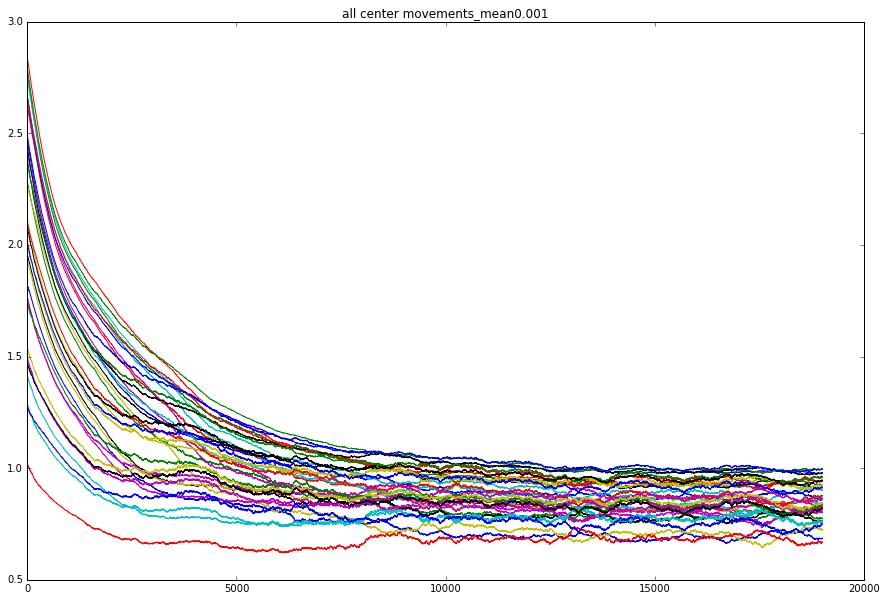

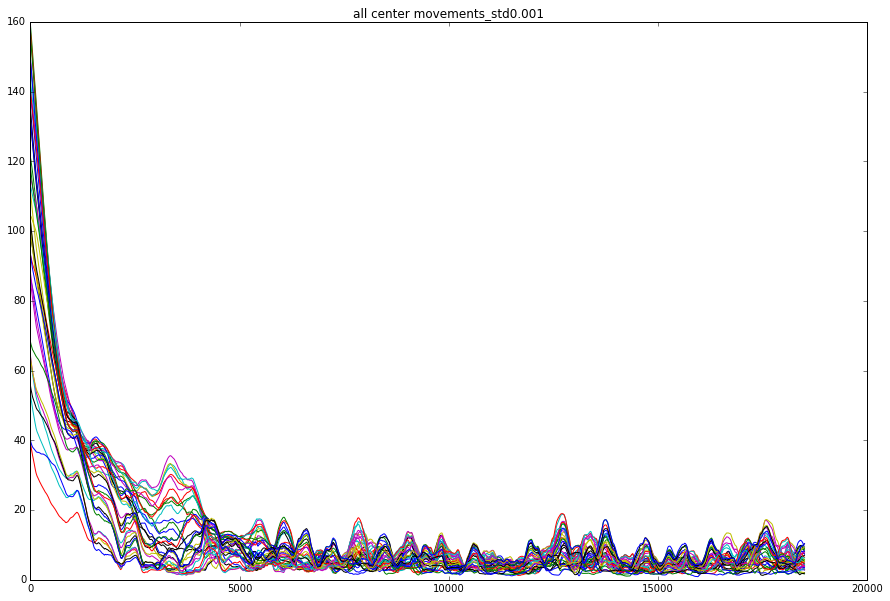

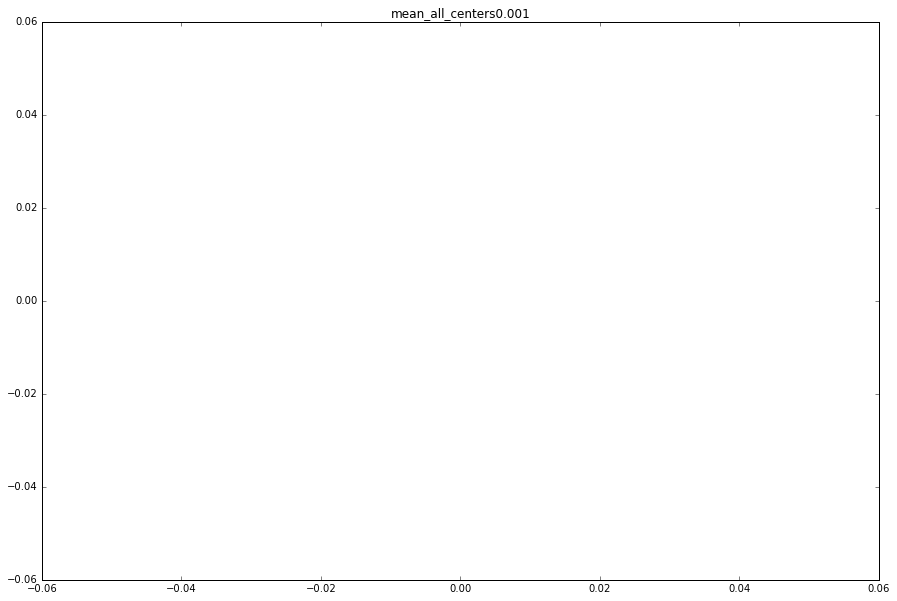

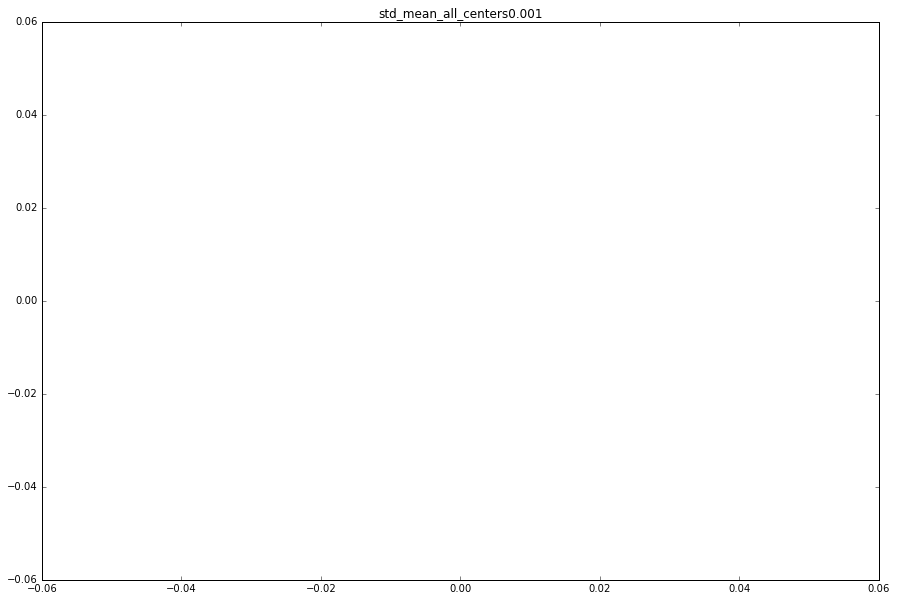

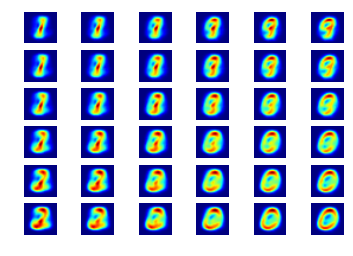

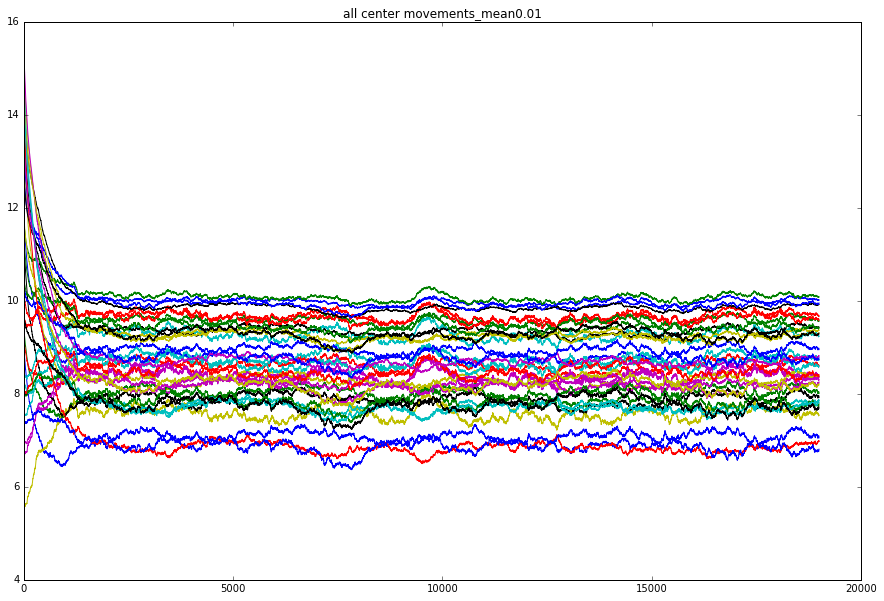

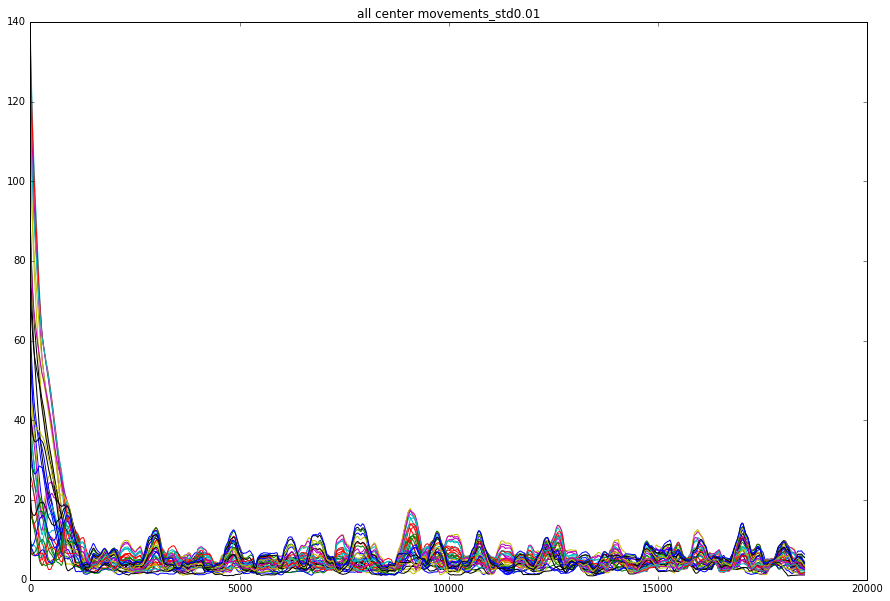

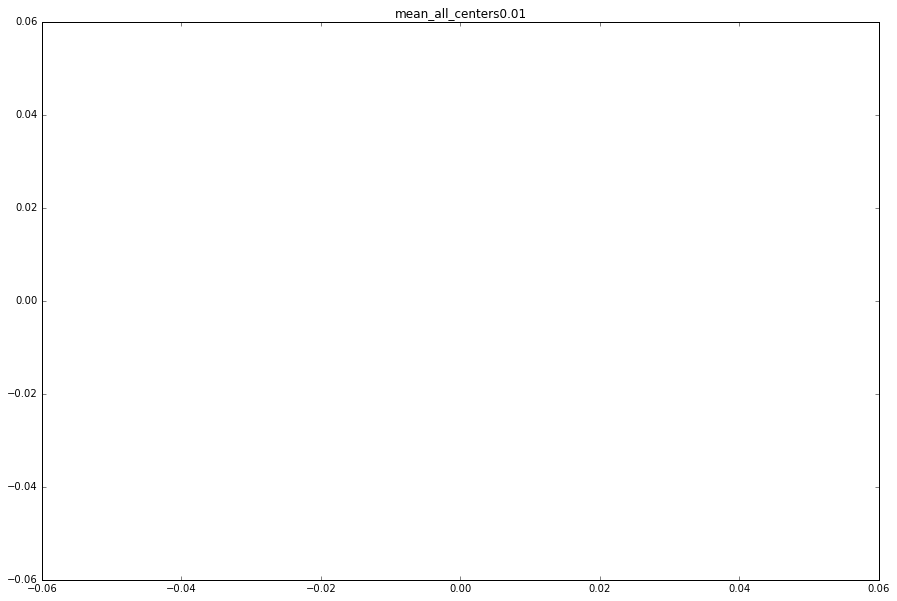

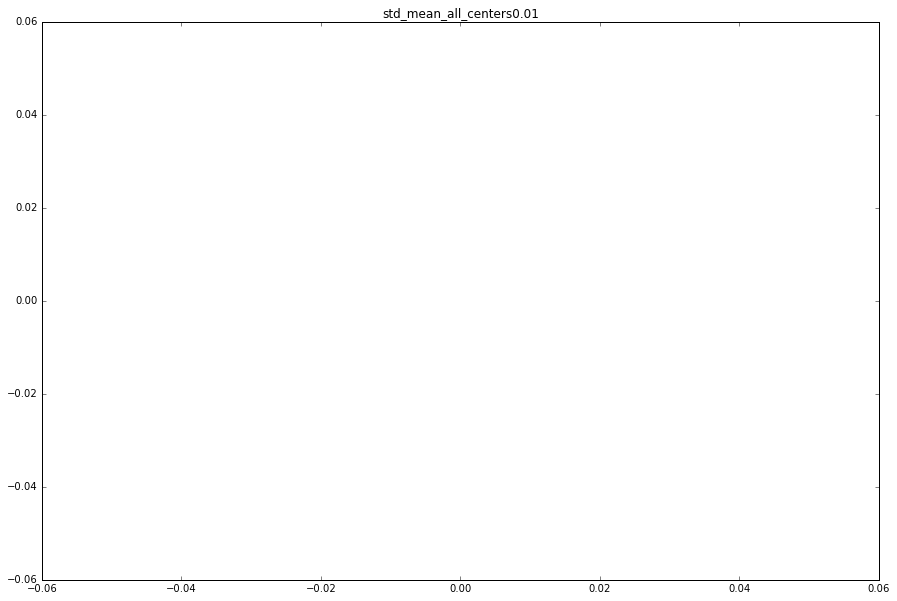

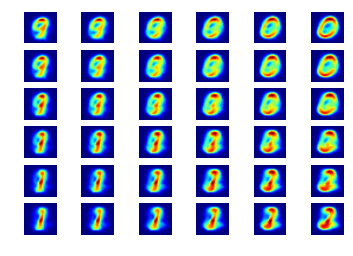

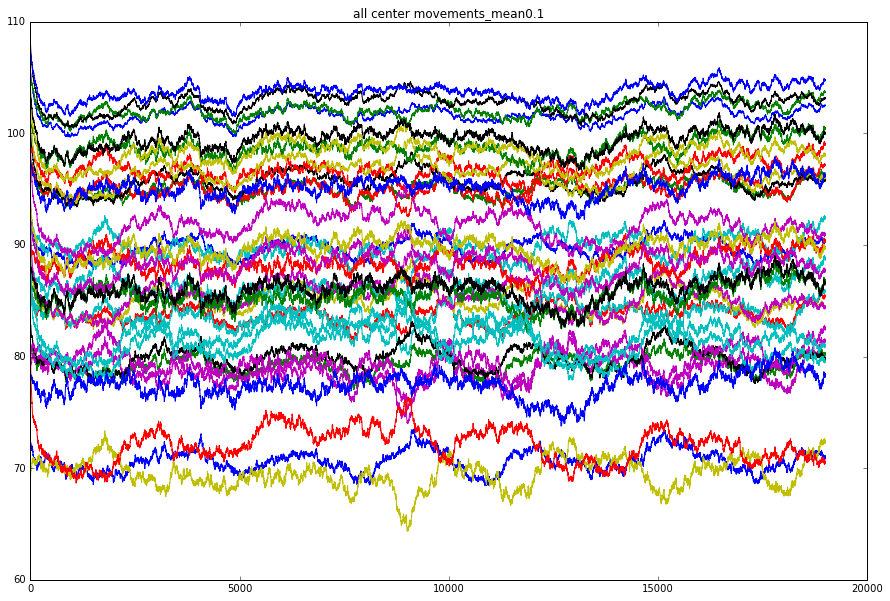

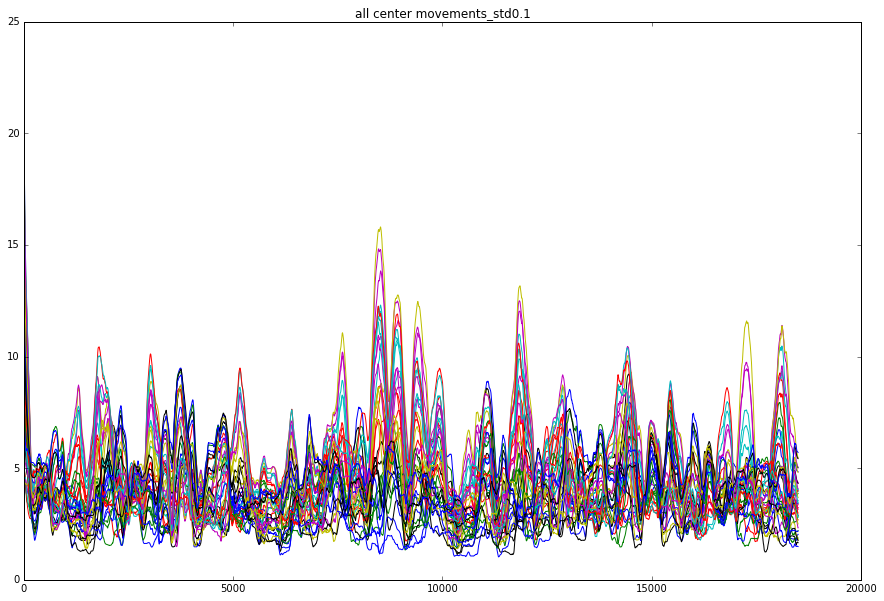

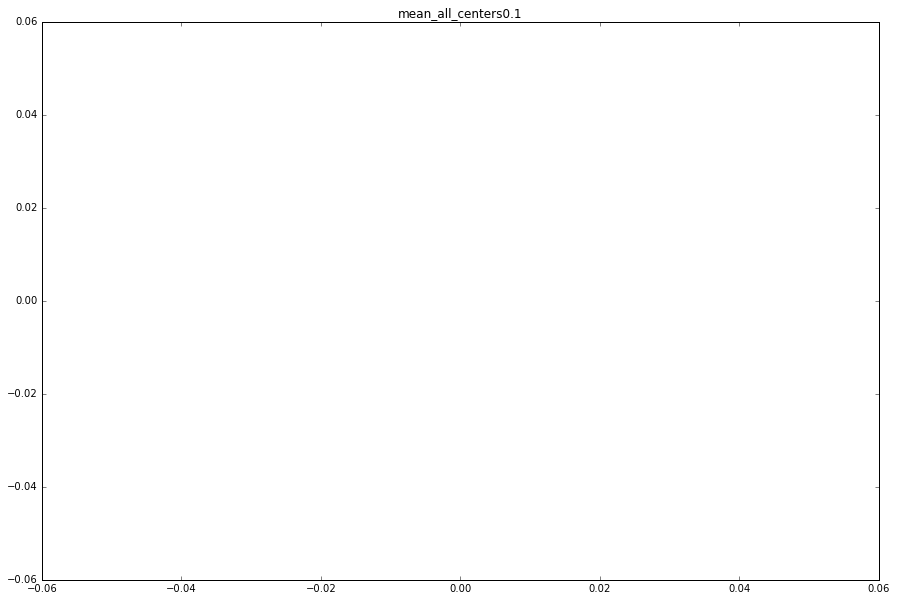

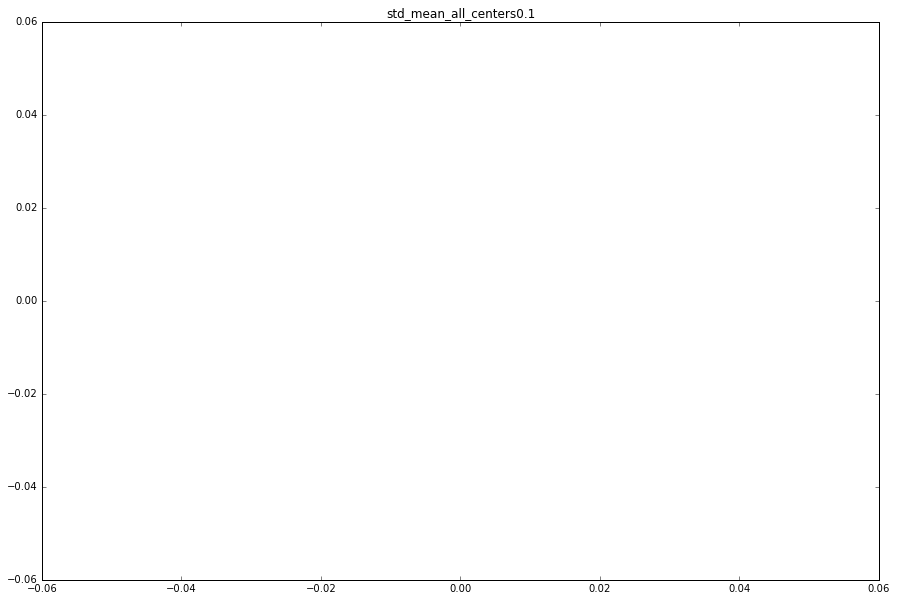

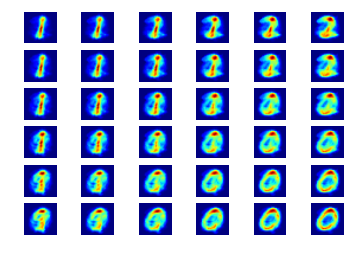

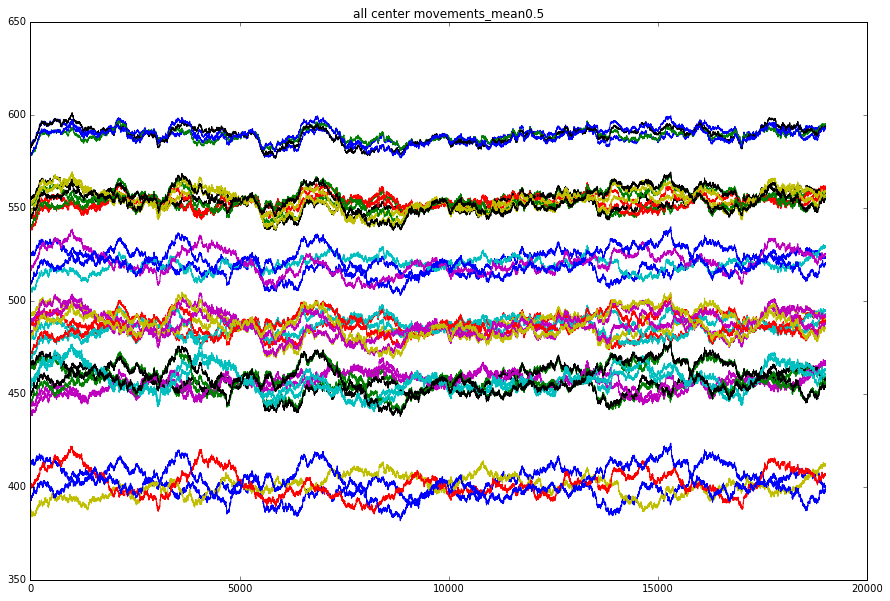

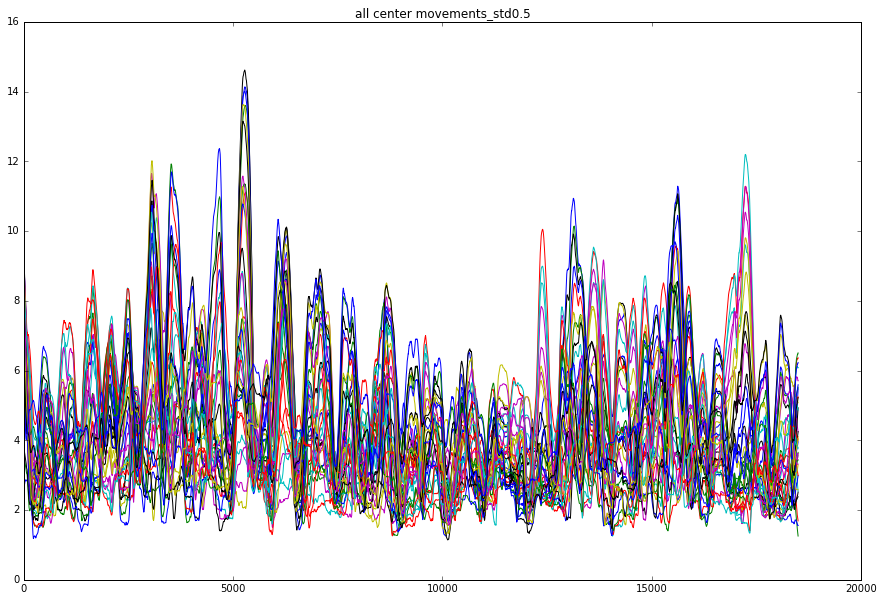

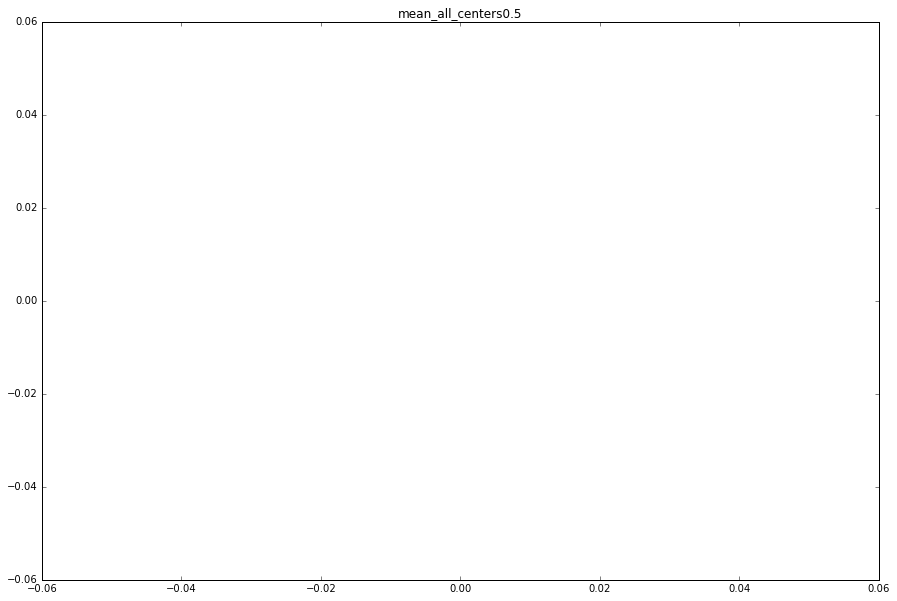

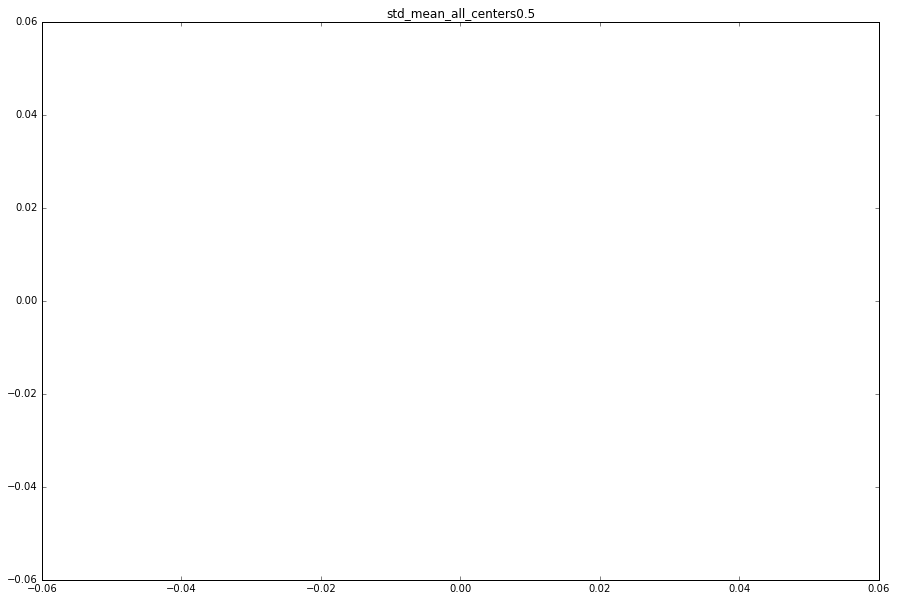

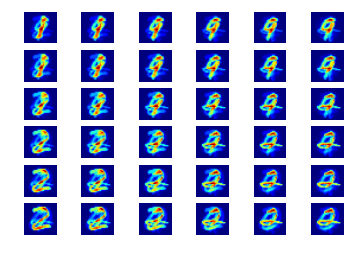

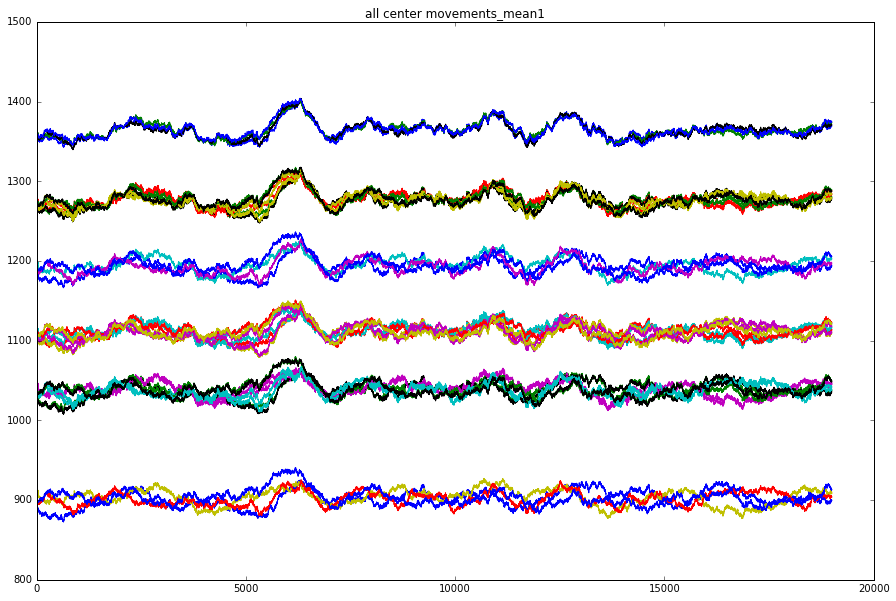

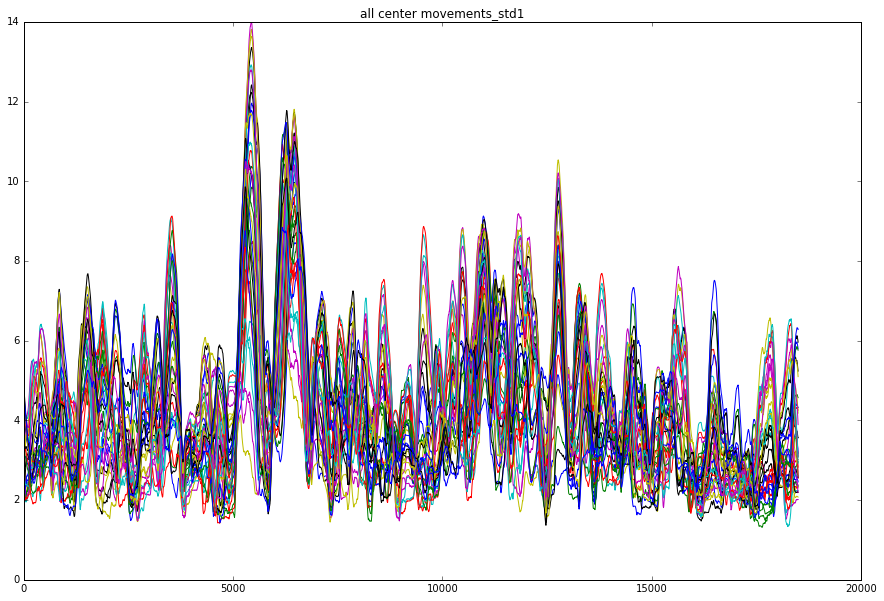

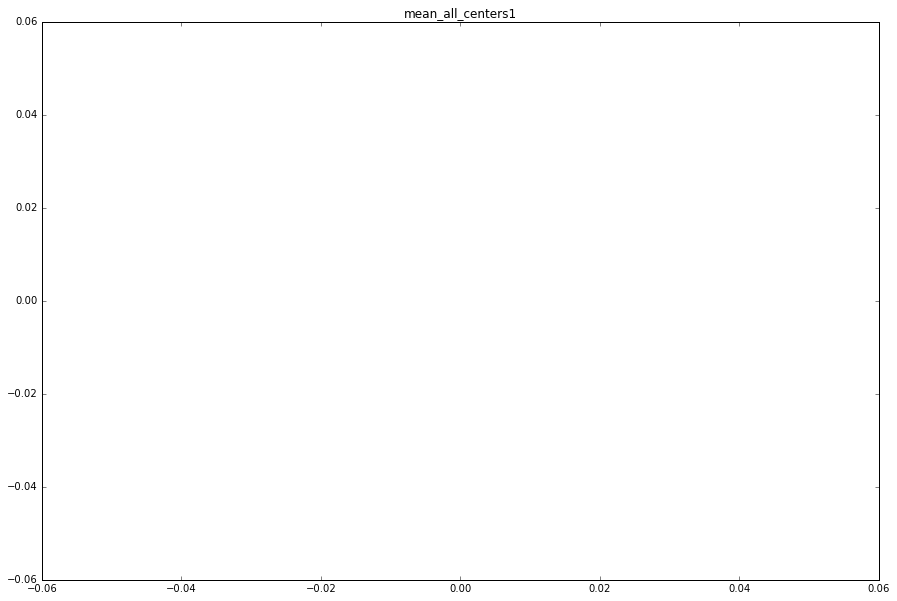

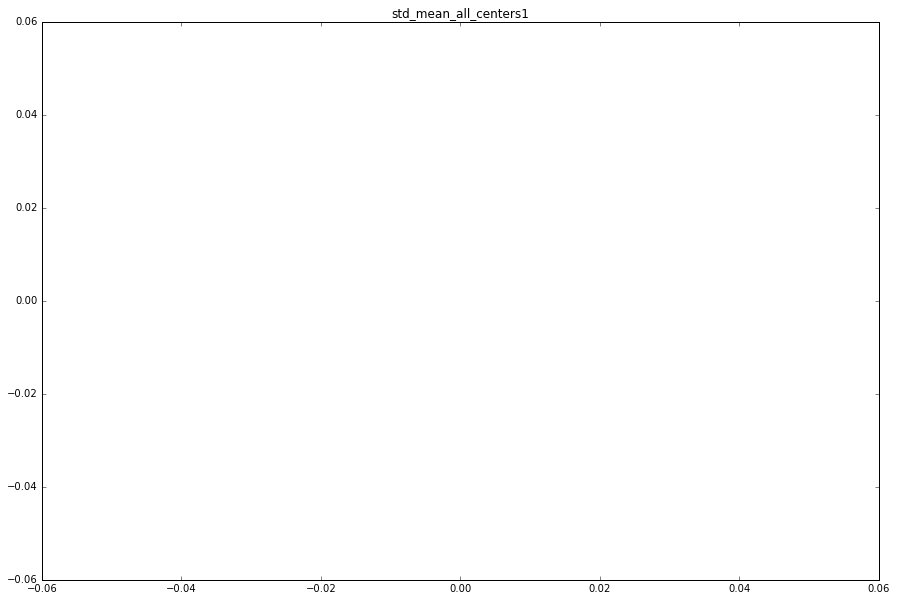

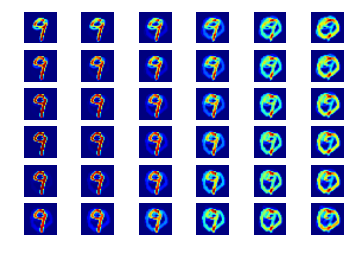

In [11]:
tmax = 20000
etas = [0.001, 0.01, 0.1, 0.5, 1]
figs = []
legends = defaultdict(lambda: [])
# load in data and labels
data = np.array(np.loadtxt('data.txt'))
labels = np.loadtxt('labels.txt')
targetdigits = name2digits("Lukas Pestalozzi")

for e in etas:
    print("\n----------------------------------")
    print("Eta:", e)
    plt_dict = kohonen_test(max_iter=tmax, R=0, init_eta=e, init_sigma=3.0,
                                                   W_movement = len(data),
                                                   movment_limit = 0.0,
                                                   stab_limit=0,
                                                   data=data, labels=labels)
    i = 0
    for k in sorted(plt_dict, key=lambda x: x[1]):
        if len(figs) <= i : 
            figs.append(plt.figure(str(i), figsize=(15, 10)))
            plt.title(k)
            #plt.ylim(0, 1)
            
        v = plt_dict[k]
        plt.figure(str(i))
        h, = plt.plot([x[0] for x in v], [x[1] for x in v])
        legends[i].append(h)
        i+=1
    
legnd = [str(e) for e in etas]
for i in range(0, len(figs)):
    plt.figure(str(i))
    plt.legend(legends[i], legnd, loc=1)
        

In [12]:
"""
def kohonen(max_iter=5, R=1, init_eta=0.1, movment_limit = 0.1, stab_limit=0.1 ,
            W_movement = 2000, init_sigma=3.0, 
            learning_rate_fun=lambda x: x, 
            sigma_fun=lambda x, y: x,
           data=None, labels=None, targetdigits=None):

    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels
    if data is None:
        data = np.array(np.loadtxt('data.txt'))
    if labels is None:
        labels = np.loadtxt('labels.txt')

    # select 4 digits
    if targetdigits is None:
        name = 'Lukas Pestalozzi'
        targetdigits = name2digits(name) # assign the four digits that should be used
        
    print(targetdigits) # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = init_sigma
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = init_eta
    
    #set the maximal iteration count
    tmax = max_iter
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)

    
    # center movement dict:
    T_movement = 0
    center_movement_dict = init_center_movment_dict(centers)
    
    
    center_movement = defaultdict(lambda: [])
    center_movement_score = []
    center_movement_score_plot = []

    
    eta_array = [eta]
    sigma_array = [sigma]
    
    do_stop = False
    for t, i in enumerate(i_random):
        som_step(centers, data[i,:],neighbor,eta,sigma)
        # update stepsize
        eta = learning_rate_fun(eta)
        eta_array.append(eta)
        # update sigma
        sigma = sigma_fun(sigma, center_movement['moving_score'][-1] if len(center_movement['moving_score']) > 0 else 1000)
        sigma_array.append(sigma)
        
        # center movement
        T_movement += 1
        update_center_movment(center_movement_dict, np.copy(centers), T_movement)
        s = 0
        for c, v in center_movement_dict.items():
            center_movement[c].append(v[0])
            s += v[0]
        
        center_movement['mean'].append(s / len(center_movement_dict))

        if len(center_movement['mean']) > W_movement:
            run_avg = np.var(center_movement['mean'][-W_movement:])
            run_avg /= eta # scale by eta
            center_movement_score.append(run_avg)
            center_movement_score_plot.append((t, run_avg))
        
        
        # show stuff
        if t % 1000 == 998:
            print("\n", t, end="")
            print(" > sigma:", sigma, end="")
            print(" > eta:", eta, end="")
            if len(center_movement_score) > 0:
                print(" > movment score:", center_movement_score[-1], end="")
                               
        if t % 100 == 0:
            print(".", end="")
        
        # stopping criterias:
        last_x = 10
        if (len(center_movement_score) > last_x and sum([m_s < movment_limit for m_s in center_movement_score[-last_x:]]) == last_x):
            print('\nmovment limit reached')
            do_stop = True
        
        if do_stop:
            print("stopped at iteration", t)
            break
    
    # for visualization
    plt.figure("centers"+str(eta))
    tle = "eta:"+str(eta)
    plt.title(tle)
    for i in range(size_k**2):
        plt.subplot(size_k,size_k,i+1)
        plt.axis('off')
        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        
    plt.figure("all_center_movements", figsize=(15, 10))
    plt.ylim(0, 8)
    for c, v in center_movement_dict.items():
        plt.plot(center_movement[c])
    plt.title("all center movements")
    
    plt.figure("mean_center_movements", figsize=(15, 10))
    plt.ylim(0, 8)
    plt.plot(center_movement["mean"])
    plt.title("mean of all center movements")
    
        
    # build the dict with all the arrays that should be plotted:
    plot_dict = {
        #"stability scores" : stab_scores_plot,
        "center movment score": center_movement_score_plot
    }
    
    return plot_dict
"""

'\ndef kohonen(max_iter=5, R=1, init_eta=0.1, movment_limit = 0.1, stab_limit=0.1 ,\n            W_movement = 2000, init_sigma=3.0, \n            learning_rate_fun=lambda x: x, \n            sigma_fun=lambda x, y: x,\n           data=None, labels=None, targetdigits=None):\n\n    \n    dim = 28*28\n    data_range = 255.0\n    \n    # load in data and labels\n    if data is None:\n        data = np.array(np.loadtxt(\'data.txt\'))\n    if labels is None:\n        labels = np.loadtxt(\'labels.txt\')\n\n    # select 4 digits\n    if targetdigits is None:\n        name = \'Lukas Pestalozzi\'\n        targetdigits = name2digits(name) # assign the four digits that should be used\n        \n    print(targetdigits) # output the digits that were selected\n    # this selects all data vectors that corresponds to one of the four digits\n    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]\n    \n    dy, dx = data.shape\n    \n    #set the size of the Kohonen map. In this case i